# Data preprocessing¶and image embedding

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import csv
import pandas as pd
from torchvision import transforms
from PIL import Image

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("data_pre_processing2").getOrCreate()


In [4]:
import os
os.chdir("/home/hduser/Descargas/weather")


In [5]:
folder = "hdfs://localhost:9000/user1/weather"
#directory with images folder

In [6]:
image_df= spark.read.format("binaryFile").option("pathGlobFilter", "*.jpg").load(folder)

In [7]:
# input dimensions for the CNN
input_dim = (224,224)
input_dir_cnn = "hdfs://localhost:9000/image/input_images_cnn"

In [8]:
os.makedirs(input_dir_cnn, exist_ok = True)


In [9]:
transformation_for_cnn_input = transforms.Compose([transforms.Resize(input_dim)])


In [10]:
output_dir = 'image/output_images_cnn'


In [11]:
folder = "hdfs://localhost:9000/image" 
input_dir_cnn = output_dir  

os.makedirs(input_dir_cnn, exist_ok=True)

for item in os.listdir(folder):
    item_path = os.path.join(folder, item)

    
    if os.path.isfile(item_path):  # if is a file
        I = Image.open(item_path)

        
        if I.mode != 'RGB': # convert in RGB (colors)
            I = I.convert('RGB')

        
        newI = transformation_for_cnn_input(I) # transform for cnn

        
        newI.save(os.path.join(input_dir_cnn, item)) # save in jpeg

        # close images
        I.close()
        newI.close()


In [12]:
import torch
from torchvision import models
from PIL import Image

In [13]:
class Img2VecResnet18():
    
    def __init__(self):
        
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer() 
        self.model = self.model.to(self.device) 
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])
        
    def getFeatureLayer(self):
    
        cnnModel = models.resnet18(pretrained=True) 
        layer = cnnModel._modules.get('avgpool') 
        self.layer_output_size = 512
        return cnnModel, layer

    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device) 
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)
        def copyData(m, i, o): embedding.copy_(o.data)
        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()
        return embedding.numpy()[0, :, 0, 0]


    


In [14]:
import tqdm
from torchvision import models, transforms 

In [15]:
img2vec = Img2VecResnet18()

In [16]:
allVectors = {}

In [17]:
for image_name in os.listdir(input_dir_cnn):
    I = Image.open(os.path.join(input_dir_cnn, image_name))
    vec = img2vec.getVec(I)
    allVectors[image_name] = vec
    I.close()

In [18]:
data_folder = os.path.expanduser('~/Descargas')

In [19]:
pd.DataFrame(allVectors).transpose().to_csv(data_folder+'/input_data_vectors.csv')


In [20]:
spark.stop()

# DL Model 

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models

2023-09-27 19:03:15.770563: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-27 19:03:18.894652: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [23]:
spark = SparkSession.builder.appName("model").getOrCreate()

2023-09-27 19:03:22,563 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [24]:
input_df = spark.read.option('inferschema',True).\
                    csv('hdfs://localhost:9000/user1/input_data_vectors.csv')
                                     

In [25]:
input_df.columns

['_c0',
 '_c1',
 '_c2',
 '_c3',
 '_c4',
 '_c5',
 '_c6',
 '_c7',
 '_c8',
 '_c9',
 '_c10',
 '_c11',
 '_c12',
 '_c13',
 '_c14',
 '_c15',
 '_c16',
 '_c17',
 '_c18',
 '_c19',
 '_c20',
 '_c21',
 '_c22',
 '_c23',
 '_c24',
 '_c25',
 '_c26',
 '_c27',
 '_c28',
 '_c29',
 '_c30',
 '_c31',
 '_c32',
 '_c33',
 '_c34',
 '_c35',
 '_c36',
 '_c37',
 '_c38',
 '_c39',
 '_c40',
 '_c41',
 '_c42',
 '_c43',
 '_c44',
 '_c45',
 '_c46',
 '_c47',
 '_c48',
 '_c49',
 '_c50',
 '_c51',
 '_c52',
 '_c53',
 '_c54',
 '_c55',
 '_c56',
 '_c57',
 '_c58',
 '_c59',
 '_c60',
 '_c61',
 '_c62',
 '_c63',
 '_c64',
 '_c65',
 '_c66',
 '_c67',
 '_c68',
 '_c69',
 '_c70',
 '_c71',
 '_c72',
 '_c73',
 '_c74',
 '_c75',
 '_c76',
 '_c77',
 '_c78',
 '_c79',
 '_c80',
 '_c81',
 '_c82',
 '_c83',
 '_c84',
 '_c85',
 '_c86',
 '_c87',
 '_c88',
 '_c89',
 '_c90',
 '_c91',
 '_c92',
 '_c93',
 '_c94',
 '_c95',
 '_c96',
 '_c97',
 '_c98',
 '_c99',
 '_c100',
 '_c101',
 '_c102',
 '_c103',
 '_c104',
 '_c105',
 '_c106',
 '_c107',
 '_c108',
 '_c109',
 '_c110',


In [26]:
from pyspark.ml.feature import VectorAssembler

In [27]:
vector_columns = input_df.columns[1:]

In [28]:
assembler = VectorAssembler(inputCols = vector_columns, outputCol = "features")

In [29]:
output = assembler.transform(input_df)

In [30]:
output = output.select('_c0','features')

In [31]:
output.show(3, vertical = True)

2023-09-27 19:03:29,578 WARN util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


-RECORD 0------------------------
 _c0      | null                 
 features | [0.0,1.0,2.0,3.0,... 
-RECORD 1------------------------
 _c0      | cloudy126.jpg        
 features | [0.20776045,0.534... 
-RECORD 2------------------------
 _c0      | rain20.jpg           
 features | [0.07726963,1.333... 
only showing top 3 rows



In [32]:
output.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- features: vector (nullable = true)



In [33]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

In [34]:
#remove first row in the dataframe, adding column with index
output = output.withColumn("index", F.monotonically_increasing_id())
min_index = output.select(F.min("index")).first()[0]

# filter rows
filtered_df = output.filter(output["index"] > min_index)

# drop index
filtered_df = filtered_df.drop("index")

filtered_df.show(3)

+-------------+--------------------+
|          _c0|            features|
+-------------+--------------------+
|cloudy126.jpg|[0.20776045,0.534...|
|   rain20.jpg|[0.07726963,1.333...|
|   rain34.jpg|[0.48569173,1.763...|
+-------------+--------------------+
only showing top 3 rows



In [35]:
def label_image(x):
    if x.startswith("rain"):
        return "rain"
    elif x.startswith("cloudy"):
        return "cloudy"
    elif x.startswith("shine"):
        return "shine"
    elif x.startswith("sunrise"):
        return "sunrise"
    else:
        return "other"

In [36]:
import pandas as pd 

In [37]:
df= filtered_df.toPandas()

In [38]:
df["label"] = df["_c0"].apply(label_image)

In [39]:
df.head()

,_c0,features,label
0,cloudy126.jpg,"[0.20776045, 0.5349115, 0.06763665, 0.26847824...",cloudy
1,rain20.jpg,"[0.07726963, 1.3335361, 0.47853556, 0.03628950...",rain
2,rain34.jpg,"[0.48569173, 1.7636161, 0.4241169, 0.7579224, ...",rain
3,cloudy132.jpg,"[0.30124563, 0.08039489, 0.10868763, 0.4784735...",cloudy
4,sunrise33.jpg,"[0.46167415, 2.0126479, 0.61442626, 0.20303471...",sunrise


In [40]:
# define X and y for the model
X = np.array(df['features'].tolist())  # Features vettorializzate
y = df['label']  


In [41]:

# label encoded
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [42]:
# split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [43]:
# Create model
model = models.Sequential([
    layers.Input(shape=(len(X_train[0]),)),  # Input layer con dimensioni delle features
    layers.Dense(128, activation='relu'),  # Hidden layer 1
    layers.Dense(64, activation='relu'),   # Hidden layer 2
    layers.Dense(len(label_encoder.classes_), activation='softmax')  # Output layer
])



In [44]:
# compile
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [45]:
import time

In [46]:
# Train

model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
23/23 [==============================] - 1s 23ms/step - loss: 0.5784 - accuracy: 0.8014 - val_loss: 0.2058 - val_accuracy: 0.9500
Epoch 2/10
23/23 [==============================] - 0s 19ms/step - loss: 0.1327 - accuracy: 0.9681 - val_loss: 0.1292 - val_accuracy: 0.9444
Epoch 3/10
23/23 [==============================] - 0s 17ms/step - loss: 0.0846 - accuracy: 0.9750 - val_loss: 0.1273 - val_accuracy: 0.9722
Epoch 4/10
23/23 [==============================] - 0s 20ms/step - loss: 0.0764 - accuracy: 0.9750 - val_loss: 0.1014 - val_accuracy: 0.9667
Epoch 5/10
23/23 [==============================] - 0s 14ms/step - loss: 0.0505 - accuracy: 0.9889 - val_loss: 0.0918 - val_accuracy: 0.9722
Epoch 6/10
23/23 [==============================] - 0s 17ms/step - loss: 0.0400 - accuracy: 0.9889 - val_loss: 0.0941 - val_accuracy: 0.9667
Epoch 7/10
23/23 [==============================] - 0s 15ms/step - loss: 0.0346 - accuracy: 0.9917 - val_loss: 0.0999 - val_accuracy: 0.9611
Epoch 8/10
23

In [47]:
# evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_accuracy)


8/8 [==============================] - 0s 7ms/step - loss: 0.0990 - accuracy: 0.9689
0.9688888788223267


In [48]:
spark.stop()

# Second CNN Model VGG16

In [49]:
import warnings
warnings.filterwarnings("ignore")

In [50]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("cnn").getOrCreate()

2023-09-27 19:03:42,936 WARN util.Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [51]:
from sklearn.preprocessing import LabelBinarizer
import cv2
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [52]:
import os
os.chdir("/home/hduser/Descargas/weather")


In [53]:
folder = "/home/hduser/Descargas/weather"
#directory with images folder

In [54]:
images = []
labels = []

# image size
image_size = (224, 224)


In [55]:
# scan folder
for x in os.listdir(folder):
    image_path = os.path.join(folder, x)
    pic = cv2.imread(image_path)
    if pic is not None: # check if image is loaded
       
        if x.startswith("rain"):# creation of labels based on image classifications
            label = "rain"
        elif x.startswith("cloudy"):
            label = "cloudy"
        elif x.startswith("shine"):
            label = "shine"
        elif x.startswith("sunrise"):
            label = "sunrise"
        else:
            label = "other" 
            
       
        pic = cv2.resize(pic, image_size) # adjust size
        
        images.append(pic)
        labels.append(label)

In [56]:
# Verify unique labels
unique_labels = np.unique(labels)

print(unique_labels)

['cloudy' 'rain' 'shine' 'sunrise']


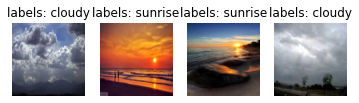

In [57]:
num_images = min(4, len(images)) # check images are loaded

s_four = np.random.choice(len(images), num_images, replace=False) # Extract 4 images randomly

# plot 
for i, idx in enumerate(s_four):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))  
    plt.title(f"labels: {labels[idx]}")
    plt.axis('off')

plt.show()

In [58]:
label_counts = {"rain": 0, "cloudy": 0, "shine": 0, "sunrise": 0, "other": 0}

In [59]:
for label in labels: # count num images per category
    label_counts[label] += 1

for label, count in label_counts.items():
    print(f"{label}: {count}")

rain: 214
cloudy: 300
shine: 252
sunrise: 357
other: 0


In [60]:
label_binarizer = LabelBinarizer()

one_hot_labels = label_binarizer.fit_transform(labels) # one-hot encoding for labels

In [61]:
# normalize pixel 

images = np.array(images)
images = images.astype(np.float32)# data must be an array float32

images /= 255.0
# check data is in interval 0 and 1
print(np.min(images))
print(np.max(images))

0.0
1.0


In [62]:
#split dataset train and test
from sklearn.model_selection import train_test_split

X_train_test, X_val, y_train_test, y_val = train_test_split(images, one_hot_labels, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_train_test, y_train_test, test_size=0.25, random_state=42)



In [63]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))# load pre-trained model VGG16

In [64]:
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(4, activation='softmax')(x)  # 4 categories: cloudy, rain, shine, sunrise

In [65]:
model = Model(inputs=base_model.input, outputs=x) # final model

In [66]:
# freeze weights
for layer in base_model.layers:
    layer.trainable = False

In [67]:

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [68]:
%%time
cnn_fit = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

2023-09-27 19:03:59.301601: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 405221376 exceeds 10% of free system memory.


Epoch 1/10


2023-09-27 19:04:01.106985: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-09-27 19:04:01.511098: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2023-09-27 19:04:02.892622: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102760448 exceeds 10% of free system memory.
2023-09-27 19:04:02.969266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 205520896 exceeds 10% of free system memory.


22/22 [==============================] - 235s 11s/step - loss: 1.0456 - accuracy: 0.5721 - val_loss: 0.7020 - val_accuracy: 0.7244
Epoch 2/10
22/22 [==============================] - 181s 8s/step - loss: 0.4615 - accuracy: 0.8276 - val_loss: 0.4639 - val_accuracy: 0.8178
Epoch 3/10
22/22 [==============================] - 227s 10s/step - loss: 0.2643 - accuracy: 0.9049 - val_loss: 0.3410 - val_accuracy: 0.8711
Epoch 4/10
22/22 [==============================] - 215s 10s/step - loss: 0.1982 - accuracy: 0.9361 - val_loss: 0.3370 - val_accuracy: 0.8711
Epoch 5/10
22/22 [==============================] - 214s 10s/step - loss: 0.1398 - accuracy: 0.9688 - val_loss: 0.2862 - val_accuracy: 0.8889
Epoch 6/10
22/22 [==============================] - 298s 14s/step - loss: 0.1382 - accuracy: 0.9658 - val_loss: 0.3478 - val_accuracy: 0.8667
Epoch 7/10
22/22 [==============================] - 179s 8s/step - loss: 0.0961 - accuracy: 0.9777 - val_loss: 0.2690 - val_accuracy: 0.9022
Epoch 8/10
22/22 [=

In [69]:
# evaluation
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(test_accuracy)


8/8 [==============================] - 47s 6s/step - loss: 0.2785 - accuracy: 0.8933
0.8933333158493042


In [70]:
spark.stop()